In [1]:
!pip install -q torch==1.4.0 torchvision==0.5

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 55.6MB/s 


In [ ]:

!pip install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-geometric


In [ ]:
#pip install "neuralnet-pytorch[geom] @ git+git://github.com/justanhduc/neuralnet-pytorch.git@master"

In [ ]:
#!pip install neuralnet-pytorch

In [ ]:
#!pip install git+git://github.com/justanhduc/neuralnet-pytorch.git@fancy

**Go to directory where the model and data are stored**

In [5]:
cd drive/My\ Drive/Gitlink/Version1_Fixed\ Nodes

/content/drive/My Drive/Gitlink


In [ ]:
## Import all potential models, files and functions that could be useful
from __future__ import division
from __future__ import print_function
import argparse
import time
import torch_geometric
import numpy as np
import scipy.sparse as sp
import torch
from torch import optim
from torch_geometric.data import Data
from model import GCN_Message
from optimizer2 import loss_function
#from utils import load_data, mask_test_edges, preprocess_graph, get_roc_score
import torch.nn.functional as F
import time 
from torch.utils.data import Dataset, IterableDataset, DataLoader
from itertools import cycle, islice
import iterableJet
from iterableJet import IterableMuons
import class_jet
from class_jet import FCMuonsGPU
from torch.optim.lr_scheduler import StepLR

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


parser = argparse.ArgumentParser()
parser.add_argument('--model', type=str, default='gcn_vae', help="models used")
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=50, help='Number of epochs to train.')
parser.add_argument('--batch_size', type=int, default=100, help='Initial learning rate.') #100
parser.add_argument('--lr', type=float, default=0.0001, help='Initial learning rate.') #0.001
parser.add_argument('--dropout', type=float, default=0.2, help='Dropout rate (1 - keep probability).')
args = parser.parse_args([])
torch.backends.cudnn.benchmark = True

In [9]:
samples=torch.load('../../Unet/ECAL_f01_june.pt')

In [10]:
#Log-Scaling of the last column containing energies to make it within the same range of the positions (columns 0 and 1)
for sample in samples:
    sample['x'][:,2]=torch.log(sample['x'][:,2])


In [12]:
## Use Iterable Dataset to better load the batches
from torch_geometric.data import DataLoader
jet=IterableMuons(samples)
loader = DataLoader(jet, batch_size=args.batch_size)

## Initialize the model 
model = GCN_Message(in_channels=3, out_channels1=64, out_channels2=128,out_channels3=512, deco2=512,deco3=128,deco4=64,num_layers=3, dropout=0.2,
                    batch_size=args.batch_size)
optimizer = optim.Adam(model.parameters(), lr=args.lr)

## If training for the first time, otherwise uncomment cell below and use it to load weights
model.train()
model.to(device)

GCN_Message(
  (dec1): Linear(in_features=64, out_features=512, bias=True)
  (dec2): SAGEConv(512, 128)
  (dec3): SAGEConv(128, 64)
  (dec4): SAGEConv(64, 3)
  (ggn): SAGEConv(3, 64)
  (ggn2): SAGEConv(64, 128)
  (ggn3): SAGEConv(128, 512)
  (tr2): Linear(in_features=512, out_features=64, bias=True)
)

In [ ]:
"""
checkpoint = torch.load('best_weights.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()
model.train()
model.to(device)
"""

GCN_Message(
  (lin1): Linear(in_features=3, out_features=150, bias=True)
  (lin2): Linear(in_features=150, out_features=150, bias=True)
  (gc1): GCNConv_Message(150, 100)
  (gc2): GCNConv_Message(150, 100)
  (dec1): Linear(in_features=64, out_features=512, bias=True)
  (dec2): Linear(in_features=512, out_features=256, bias=True)
  (dec3): Linear(in_features=256, out_features=64, bias=True)
  (dec4): Linear(in_features=64, out_features=3, bias=True)
  (lin3): Linear(in_features=1, out_features=20, bias=True)
  (lin32): Linear(in_features=20, out_features=4, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ggn): GatedGraphConv(150, num_layers=3)
  (tr1): Linear(in_features=150, out_features=100, bias=True)
  (tr2): Linear(in_features=100, out_features=64, bias=True)
)

In [ ]:
for epoch in range(25):
    #model.train()
    count=0
    epLoss=0
    t = time.time()
    for el in islice(loader,0,3000):
        gra=el.x.clone()  ##features 

        adj=el.edge_index ## edge matrix 

        count+=1
        hidden_emb = None
        orig=torch_geometric.data.Batch.to_data_list(el)

        gra=gra.to(device)
        adj=adj.to(device)

        optimizer.zero_grad()

        r1,r2, mu, logvar = model(gra,adj) ## X , A 

        loss = loss_function(r1,r2,labels=gra, mu=mu, logvar=logvar, n_nodes=32) #+loss2(logsoftmax(torch.transpose(r2,1,2)),temp.long())     


        loss.backward()
        
        cur_loss = loss.item()
        optimizer.step()
        epLoss+=cur_loss

        hidden_emb = mu.data.cpu().numpy() 
        
        if count%1500==0:
            print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(epLoss/count),
                  "time=", "{:.5f}".format(time.time() - t))
            t = time.time()
        if epoch %2==0:
            #%%
            torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              }, './best_weights.pth')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:

from torch_geometric.data import DataLoader
#jetTest=IterableMuons(testing)
#Testloader = DataLoader(testing, batch_size=200)
#%%

model.eval()
#count2=0
epLoss2=0


tests=torch.load('../f11.pt')
cols=None
#model.train()
count2=0
epLoss2=0
t = time.time()
i12,i22=0,200
#data2=get_slice(i12,i22)
#jet=IterableMuons(samples)
for k2 in range(2):
    count2+=1
    loader2 = DataLoader(tests, batch_size=200)
    for el2 in islice(loader,0,1):#for k,(gra, feats) in enumerate(loader): 
        gra2=el2.x.clone()  ##features 

        adj2=el2.edge_index ## edge matrix 

        
        hidden_emb2 = None
        orig2=torch_geometric.data.Batch.to_data_list(el2)
      
        #gra[:,:2]/=10

        #gra[:,2]*=16
        gra2[:,2]*=16

        #gra_baseline=normBatch(gra_baseline).float()

        gra2=gra2.to(device)
        adj2=adj2.to(device)
        #gra_baseline=gra_baseline.to(device)
        #optimizer.zero_grad()
                
        #gra_baseline=gra_baseline.to(device)
        r12,r22, mu2, logvar2 = model(gra2,adj2) ## X , A 

        #temp=gra[:,:,3].clone()
        loss2 = loss_function(r12,r22,labels=gra2, mu=mu2, logvar=logvar2, n_nodes=32) #+ loss3(torch.abs(detector2),gra2[:,3])      #gra_baseline[:,:,-1:].squeeze_(2).long())#+BCLoss(r2,gra) 


        cur_loss2 = loss2.item()
        optimizer.step()


        hidden_emb2 = mu2.data.cpu().numpy()


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
orig2=torch_geometric.data.Batch.to_data_list(el2)
com2=r12.detach().cpu().clone()
com3=r22.detach().cpu().clone()

In [ ]:
com4=torch.cat((com2,com3.unsqueeze_(1)),axis=1)

In [ ]:
orig2[0].clone()

Data(edge_index=[2, 324], x=[81, 3])

In [ ]:
rec2[0].clone().shape

In [ ]:
rec2=[]
i3,i4=0,0
for jet2 in orig2:
  size2=jet2['x'].shape[0]
  i4+=size2
  rec2.append(com4[i3:i4])
  i3+=size2

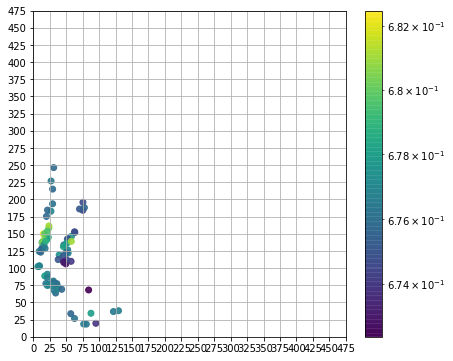

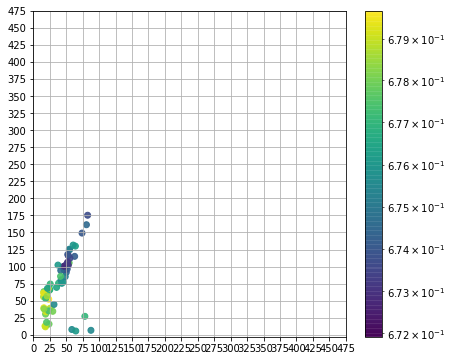

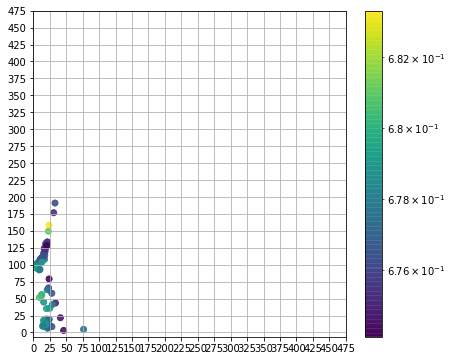

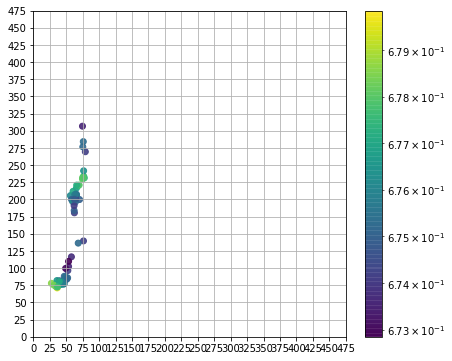

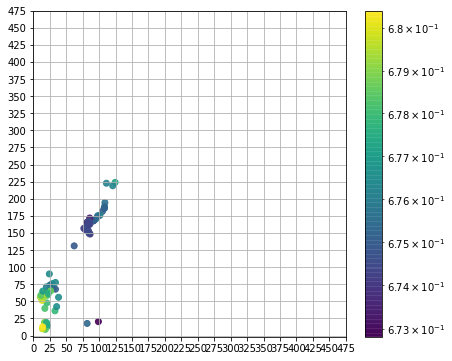

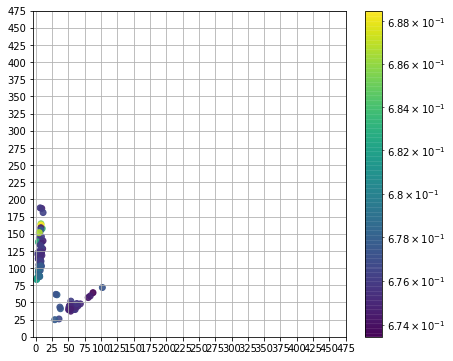

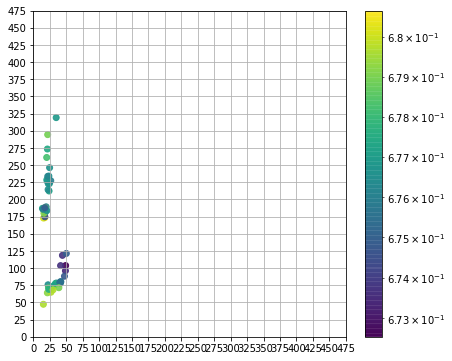

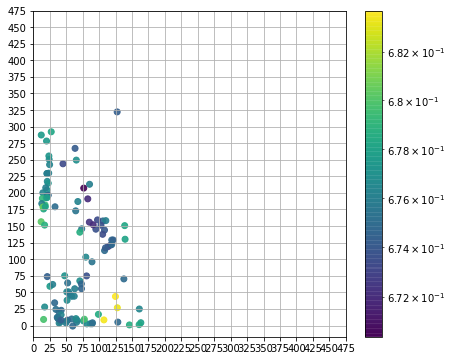

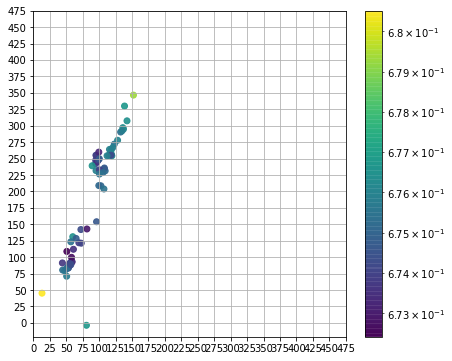

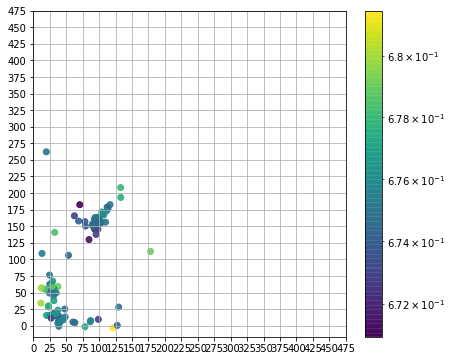

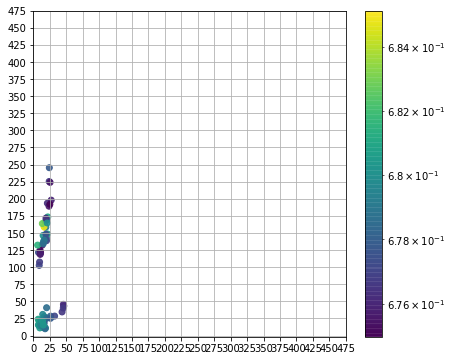

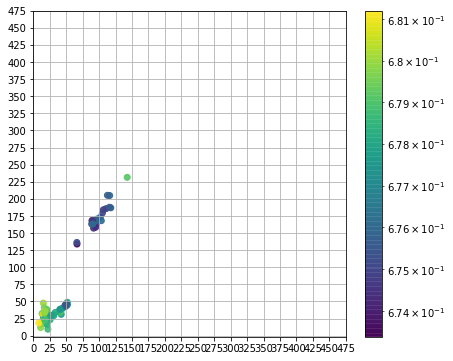

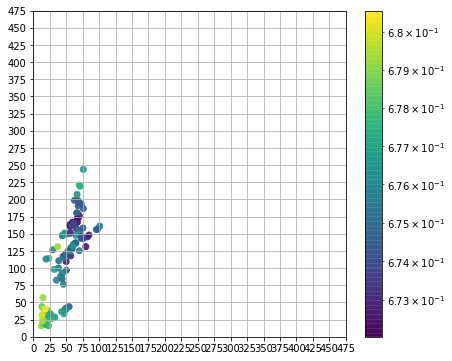

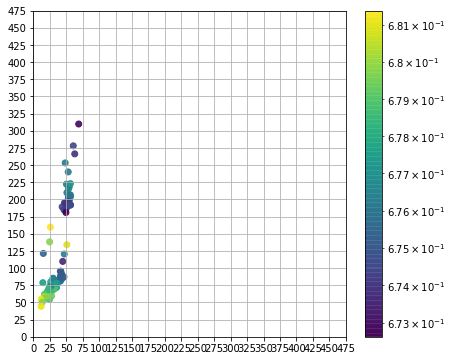

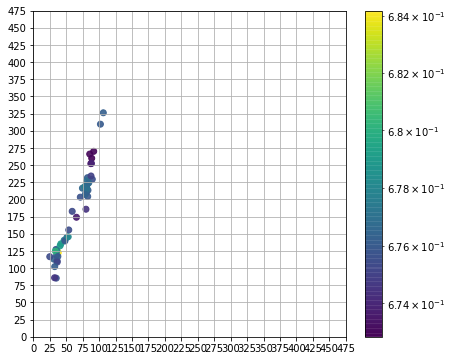

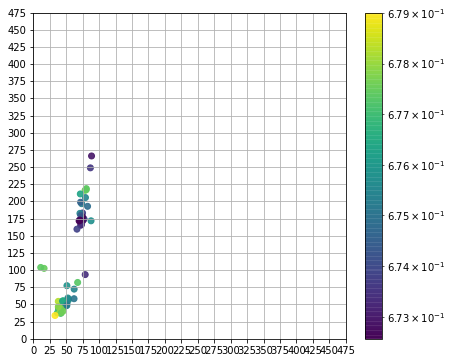

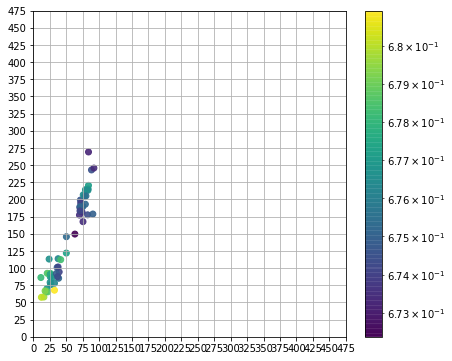

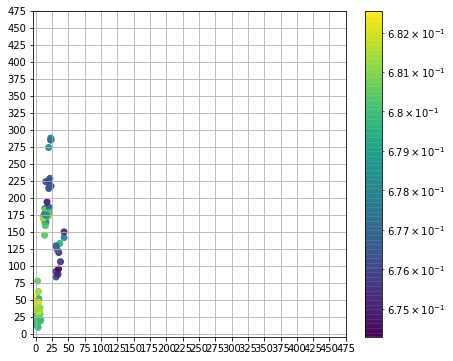

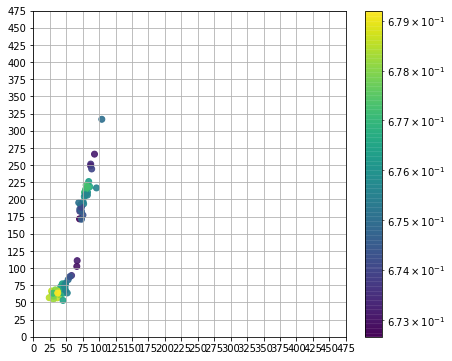

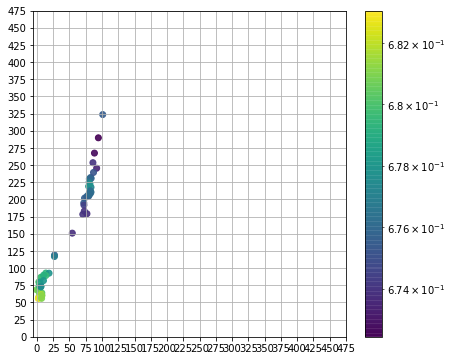

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
#xmin, xmax = min(lis4[:,0]), max(lis4[:,0])
#ymin, ymax = min(lis4[:,1]), max(lis4[:,1])
for m in range(20):
    lis4=rec2[m].clone()
    lis4=lis4.detach().numpy()
    xmin,xmax=0,500
    ymin,ymax=0,500
    binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
    weights=np.exp(lis4[:,2]/16)
    plt.figure(figsize=(7,6))
    sc = plt.scatter(lis4[:,0],lis4[:,1],c=weights,cmap='viridis',norm=LogNorm(), alpha=0.9)
    plt.colorbar(sc)
    check=np.arange(0,500,25)
    plt.xticks(check)
    plt.yticks(check)
    plt.grid()
    #plt.show()
    plt.savefig('./figs_rec/recScale'+str(m)+'.png')

In [ ]:
rec2=[]
i3,i4=0,0
for jet2 in orig2:
  size2=jet2['x'].shape[0]
  i4+=size2
  rec2.append(com4[i3:i4])
  i3+=size2

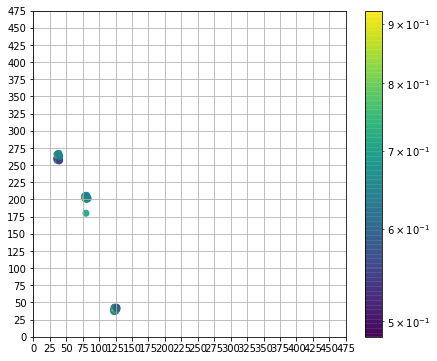

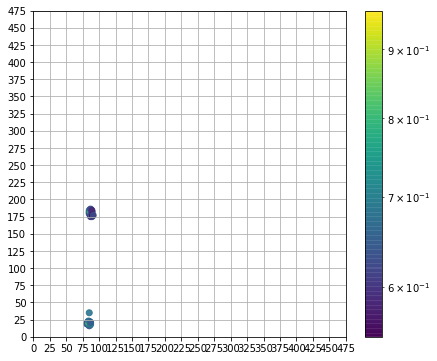

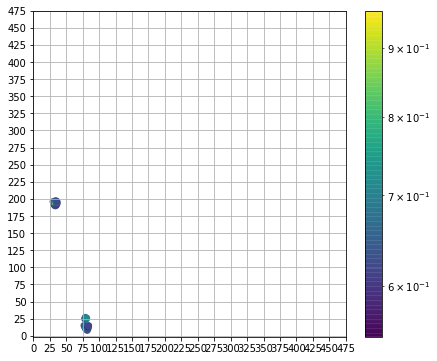

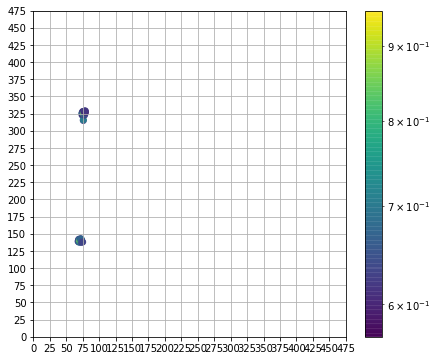

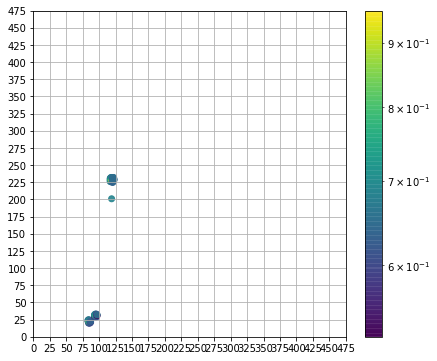

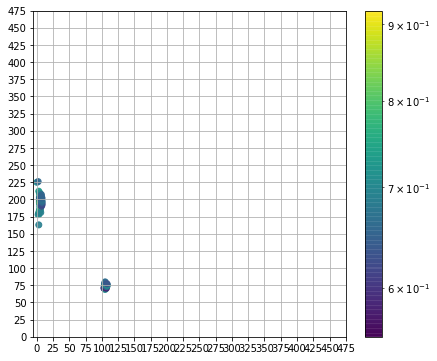

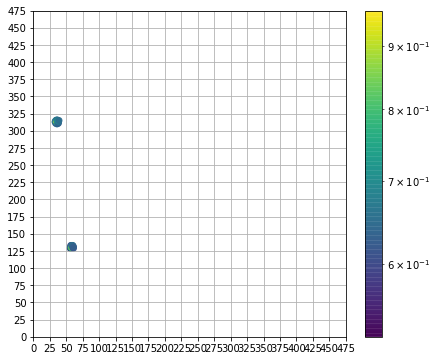

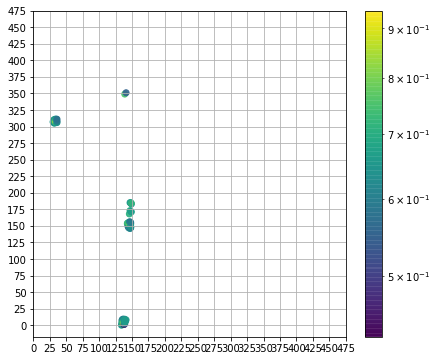

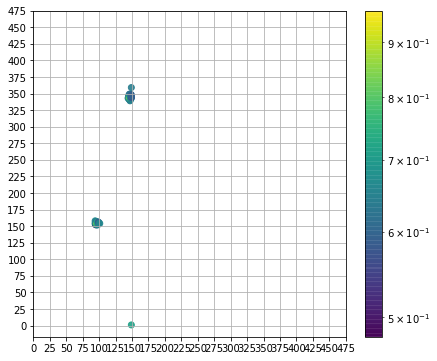

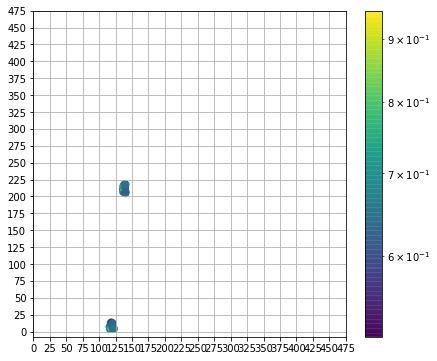

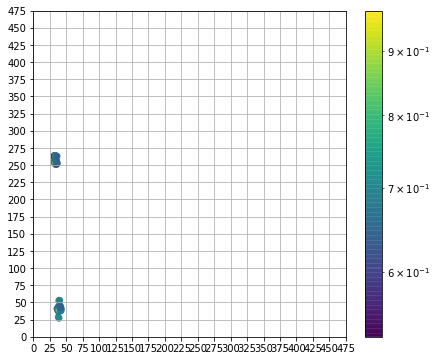

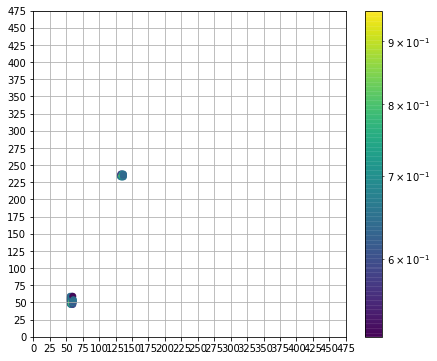

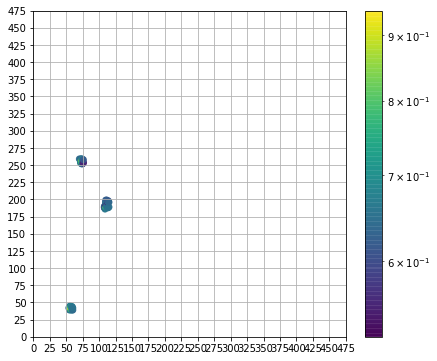

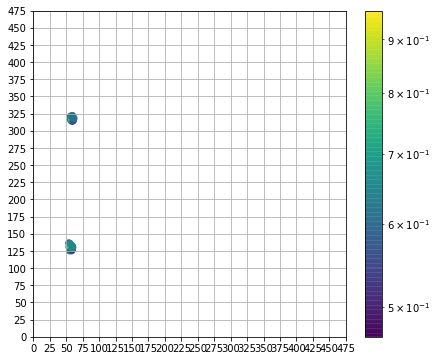

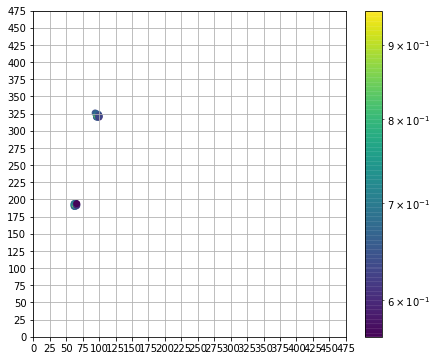

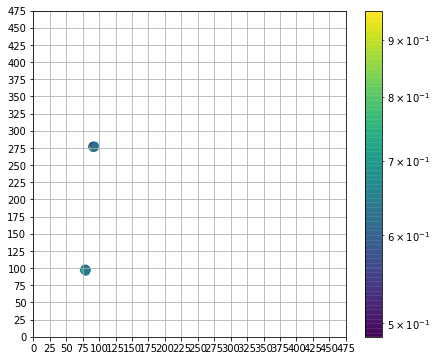

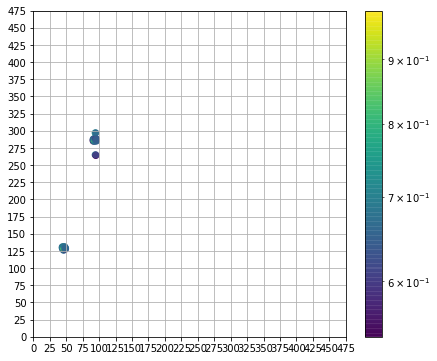

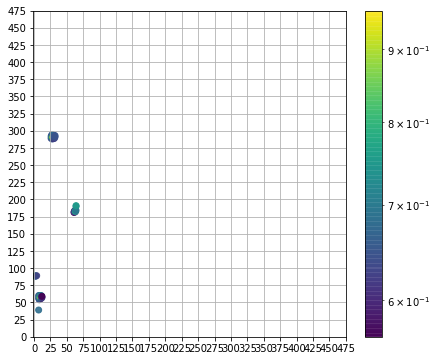

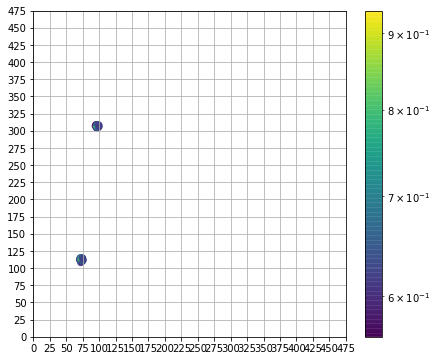

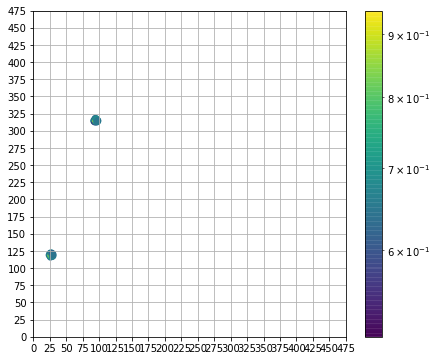

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
#xmin, xmax = min(lis4[:,0]), max(lis4[:,0])
#ymin, ymax = min(lis4[:,1]), max(lis4[:,1])
for m in range(20):
    lis4=orig2[m]['x'].clone()
    lis4=lis4.detach().numpy()
    xmin,xmax=0,500
    ymin,ymax=0,500
    binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
    weights=np.exp(lis4[:,2]/16)
    plt.figure(figsize=(7,6))
    sc = plt.scatter(lis4[:,0],lis4[:,1],c=weights,cmap='viridis',norm=LogNorm(), alpha=0.9)
    plt.colorbar(sc)
    check=np.arange(0,500,25)
    plt.xticks(check)
    plt.yticks(check)
    plt.grid()
    #plt.show()
    plt.savefig('./figs_real/realScale'+str(m)+'.png')

In [ ]:



from torch.autograd import Variable
import torch_geometric.transforms
from torch_geometric.transforms import RadiusGraph
from torch_geometric.transforms import knn_graph
import torch_geometric.data
import torch 
from torch_geometric.data import Data
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import torch
import pyarrow as pa
import pyarrow.parquet as pq
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch_geometric.nn import knn_graph

parquet = pq.ParquetFile('../Boosted_Jets_Sample-4.snappy.parquet')
cols = None
#%%

def jets(number1,number2):
    allCords=[]
    graphs=[]
    allFeats2=[]
    grIndex=[]
    for i in range(number1,number2):
        data = parquet.read_row_group(i, columns=cols).to_pydict()
        
        data['X_jets'] = np.float32(data['X_jets']) [0]
        
        ecal=data['X_jets'][1]

        ecal[ecal<=1e-3]=0
        
        xhit2,yhit2=np.nonzero(ecal)
        

        eneEcal=ecal[xhit2,yhit2]

        
        feats=np.transpose(np.vstack((xhit2,yhit2,eneEcal)))
        
        
        cords=feats[:,[0,1]]
        
        allFeats=torch.from_numpy(feats).float()
        
        cords2=torch.from_numpy(cords)
        
       
        edge_index = knn_graph(cords2, k=4, batch=None, loop=True)
        data=Data(x=allFeats,edge_index=edge_index)
        
        graphs.append(data)


    return graphs 

#%%
testing=jets(0,1000)

#%%
for sample2 in testing:
    sample2['x'][:,2]=torch.log(sample2['x'][:,2])
#%%
testingFile=torch.load('ECAL_file1_30k.pt')

testing=testingFile[:5000]

torch.save(testing,'ECAL_test_real.pt')
#%%
lis3=testing[5]['x'].clone()
#lis3[:,2]=np.exp(lis3[:,2])
lis3=lis3.numpy()
#lis3[:,2]*=4
#%%
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

for n in range(100):
    lis3=testing[n]['x'].clone()
    #lis3[:,2]=np.exp(lis3[:,2])
    lis3=lis3.numpy()
    xmin, xmax = min(lis3[:,0]), max(lis3[:,0])
    ymin, ymax = min(lis3[:,1]), max(lis3[:,1])
    
    binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
    
    weights=np.exp(lis3[:,2])
    plt.figure(figsize=(7,6))
    sc = plt.scatter(lis3[:,0],lis3[:,1],c=weights,  cmap='viridis', norm=LogNorm(),alpha=0.9)
    plt.colorbar(sc)
    check=np.arange(0,140,10)
    plt.xticks(check)
    plt.yticks(check)
    plt.grid()
    #plt.show()
    plt.savefig('./figs_real_scale/realScale'+str(n)+'.png')

#%%
    n=0
    lis3=testing[n]['x'].clone()
    #lis3[:,2]=np.exp(lis3[:,2])
    lis3=lis3.numpy()
    xmin, xmax = min(lis3[:,0]), max(lis3[:,0])
    ymin, ymax = min(lis3[:,1]), max(lis3[:,1])
    
    binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
    
    weights=np.exp(lis3[:,2])
    plt.figure(figsize=(7,6))
    sc = plt.scatter(lis3[:,0],lis3[:,1],c=weights,  cmap='viridis',norm=LogNorm(), alpha=0.9)
    plt.colorbar(sc)
    check=np.arange(0,140,10)
    plt.xticks(check)
    plt.yticks(check)
    plt.grid()
    plt.show()
#%%
from torch_geometric.data import DataLoader
#jetTest=IterableMuons(testing)
Testloader = DataLoader(testing, batch_size=100)
#%%
model.eval()
count2=0
epLoss2=0

posMom=[]
#detector=[]
with torch.no_grad():
  for el2 in islice(Testloader,1):#for k,(gra, feats) in enumerate(loader): 

    gra2=el2.x  ##features 
    adj2=el2.edge_index ## edge matrix 
    #gra_baseline2=el2.x.clone().reshape(args.batch_size,2000,4)
    #gra2[:,2]*=5
    count2+=1
    hidden_emb2 = None
    
    #gra2[:,2]=torch.exp(-gra2[:,2])
    #gra2[:,2]*=16
    #gra2[:,2]=torch.log(gra2[:,2]
    
    #gra2[:,2]=torch.log(gra2[:,2])

    #gra_baseline2=normBatch(gra_baseline2).float()

    gra2=gra2.to(device)
    adj2=adj2.to(device)
    #gra_baseline2=gra_baseline2.to(device)
    r12,r22, mu2, logvar2 = model(gra2,adj2) ## X , A 
    loss2 = loss_function(r12,r22,labels=gra2, mu=mu2, logvar=logvar2, n_nodes=32) #+loss2(logsoftmax(torch.transpose(r2,1,2)),temp.long())      #gra_baseline[:,:,-1:].squeeze_(2).long())#+BCLoss(r2,gra) 
    cur_loss2 = loss2.item()
    posMom.append(torch.cat((r12,r22.unsqueeze_(1)),axis=1))
    #detector.append(r22)
#%%
orig2=torch_geometric.data.Batch.to_data_list(el2)
com2=r12.detach().cpu().clone()
com3=r22.detach().cpu().clone()

#%%
com4=torch.cat((com2,com3.squeeze_(1)),axis=1)
#%%
rec2=[]
i3,i4=0,0
for jet2 in orig2:
  size2=jet2['x'].shape[0]
  i4+=size2
  rec2.append(com4[i3:i4])
  i3+=size2

#%%
lis4=rec2[5].clone()
lis4=lis4.detach().numpy()
#lis4[:,2]=1/np.exp((lis4[:,2]-20)/10)
#lis4[:,2]=1/lis4[:,2]

#lis4[:,2]/=4
#lis4[:,2]/=16
#lis4[:,2]=-np.exp(lis4[:,2])
#lis4[:,2]*=4
#lis4[:,2]=np.abs(lis4[:,2])

"""
lis4[:,2]/=4
"""
#lis4[:,:2]+=42
#%%
lis4
#%%

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
#xmin, xmax = min(lis4[:,0]), max(lis4[:,0])
#ymin, ymax = min(lis4[:,1]), max(lis4[:,1])
for m in range(100):
    lis4=rec2[m].clone()
    lis4=lis4.detach().numpy()
    xmin,xmax=0,125
    ymin,ymax=0,125
    binsxy = [int((xmax - xmin) / 50), int((ymax - ymin) / 50)]
    weights=np.exp(lis4[:,2])
    plt.figure(figsize=(7,6))
    sc = plt.scatter(lis4[:,0],lis4[:,1],c=weights,cmap='viridis',norm=LogNorm(), alpha=0.9)
    plt.colorbar(sc)
    check=np.arange(0,140,10)
    plt.xticks(check)
    plt.yticks(check)
    plt.grid()
    #plt.show()
    plt.savefig('./figs_rec_scale/recScale'+str(m)+'.png')
#%%
len(rec2)
#%%
"""
Testing
"""
from torch_geometric.data import DataLoader
jetTest=IterableMuons(testing)
Testloader = DataLoader(jetTest, batch_size=100)
#%%
model.eval()
count2=0
epLoss2=0

PredAll=[]
posMom=[]
#detector=[]
with torch.no_grad():
  for el2 in islice(Testloader,10):#for k,(gra, feats) in enumerate(loader): 

    gra2=el2.x  ##features 
    adj2=el2.edge_index ## edge matrix 
    #gra_baseline2=el2.x.clone().reshape(args.batch_size,2000,4)
    #gra2[:,2]*=5
    count2+=1
    hidden_emb2 = None
    

    #gra2[:,2]*=16


    #gra_baseline2=normBatch(gra_baseline2).float()

    gra2=gra2.to(device)
    adj2=adj2.to(device)
    #gra_baseline2=gra_baseline2.to(device)
    r12,r22, mu2, logvar2 = model(gra2,adj2) ## X , A 
    loss2 = loss_function(r12,r22,labels=gra2, mu=mu2, logvar=logvar2, n_nodes=32) #+loss2(logsoftmax(torch.transpose(r2,1,2)),temp.long())      #gra_baseline[:,:,-1:].squeeze_(2).long())#+BCLoss(r2,gra) 
    cur_loss2 = loss2.item()
    posMom.append(r12)
    orig2=torch_geometric.data.Batch.to_data_list(el2)
    com2=r12.detach().cpu().clone()
    com3=torch.exp(r22.detach().cpu().clone())
    com4=torch.cat((com2,com3.unsqueeze_(1)),axis=1)
    rec2=[]
    i3,i4=0,0
    for jet2 in orig2:
        size2=jet2['x'].shape[0]
        i4+=size2
        rec2.append(com4[i3:i4])
        i3+=size2
    PredAll+=rec2

    #detector.append(r22)
#%%
PredAll[0]
#%%
testing[0]['x'].
#%%
torch.save(testing,'real_120k_None.pt') 
#%%
torch.save(PredAll,'rec_120k_None.pt')    
    
    
    
    
    


In [ ]:
testing = samples[-330:]
